In [11]:
#scientific libraries and plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

#torch specific
import torch
import torchvision as torchv
import torch.optim as optim

#other libraries
import time
import sys
from pathlib import Path
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import atlas_mpl_style as ampl

#Using newest versions of all libraries

In [12]:
# import custom functions from src folder
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from machine_learning import *
from resnet import *
from resnet import ResNet18
from imcal import *
from imcal import CalorimeterDataset
from imcal import Hdf5Dataset
from imcal import RandomRoll
from imcal import plot_conf_matrix

In [13]:
#variables controlled by the user. Change these to fit your specific needs.

TRAIN_N_EVENTS = 10000 #Number of events to process for each class.
VAL_N_EVENTS = 3000 #Number of events to process for each class.
TEST_N_EVENTS = 15000 #Number of events to process for each class.
RES = 50 #resolution
CUT=True #Should cut be applied? Chooses different files if True.

#Data specification
LABELS = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "BH_n4_M8", "BH_n2_M10", "BH_n4_M10", "BH_n6_M10", "BH_n4_M12"]
TEST_LABELS = [f"{label}_test" for label in LABELS]
PLOT_LABELS = ["SPH_9", "BH_n4_M8", "BH_n2_M10", "BH_n4_M10", "BH_n6_M10", "BH_n4_M12"]
CLASSES = len(LABELS) #The number of output nodes in the net, equal to the number of classes
FOLDERS = ["sph", "BH", "BH", "BH", "BH", "BH"]

#Set data paths
if CUT:
    N_EVENTS = 10000
    TRAIN_FILENAMES = [f"{label}_res{RES}_STmin7_Nmin5_{N_EVENTS}_events.h5" for label in LABELS]
    TEST_FILENAMES = [f"{label}_res{RES}_STmin7_Nmin5_15000_events.h5" for label in TEST_LABELS]
    VAL_FILENAMES = [f"{label}_res{RES}_STmin7_Nmin5_3000_events.h5" for label in TEST_LABELS]
else:
    N_EVENTS = 10000
    TRAIN_FILENAMES = [f"{label}_res{RES}_{N_EVENTS}_events.h5" for label in LABELS]
    TEST_FILENAMES = [f"{label}_res{RES}_3000_events.h5" for label in TEST_LABELS]
    VAL_FILENAMES = [f"{label}_res{RES}_3000_events.h5" for label in TEST_LABELS]

TRAIN_DATAPATHS = [f"/disk/atlas3/data_MC/2dhistograms/{FOLDERS[i]}/{RES}/{TRAIN_FILENAMES[i]}" for i in range(CLASSES)]
VAL_DATAPATHS = [f"/disk/atlas3/data_MC/2dhistograms/{FOLDERS[i]}/{RES}/{VAL_FILENAMES[i]}" for i in range(CLASSES)]
TEST_DATAPATHS = [f"/disk/atlas3/data_MC/2dhistograms/{FOLDERS[i]}/{RES}/{TEST_FILENAMES[i]}" for i in range(CLASSES)]

#Set a unique name for the model
labelstring = '_'.join([str(elem) for elem in PLOT_LABELS])
if CUT:
    MODEL_NAME = f"resnet_{str(int(time.time()))}_{labelstring}_CUT_res{RES}"
else: MODEL_NAME = f"resnet_{str(int(time.time()))}_{labelstring}"
print(MODEL_NAME)
#Where to save the model
SAVE_FOLDER = "../results/models"
SAVE_PATH = f"{SAVE_FOLDER}/{MODEL_NAME}.pt"

#Setup GPU if available
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    torch.cuda.empty_cache()
    print("Running on the GPU")
else:
    DEVICE = torch.device("cpu")
    print("Running on the CPU")

#Data processing
#filters=["saturate", "normalise"]
filters=None
transforms = torch.nn.Sequential(
        torchv.transforms.RandomVerticalFlip(),
        RandomRoll(roll_axis=0)
    )
#For plotting
ampl.use_atlas_style()   
#sn.set_theme(context="notebook", style="white", palette="Paired", font='sans-serif', font_scale=1.5, color_codes=True, rc=None)

resnet_1696929580_SPH_9_BH_n4_M8_BH_n2_M10_BH_n4_M10_BH_n6_M10_BH_n4_M12_CUT_res50
Running on the GPU


### Load data

In [14]:
#Load data

testpaths = [Path(path) for path in TEST_DATAPATHS]
trainpaths = [Path(path) for path in TRAIN_DATAPATHS]
valpaths = [Path(path) for path in VAL_DATAPATHS]

#Load lazily to save memory
test_data = Hdf5Dataset(testpaths, TEST_LABELS, DEVICE, 
                        shuffle=False, filters=filters, transform=None, event_limit=TEST_N_EVENTS)
val_data = Hdf5Dataset(valpaths, TEST_LABELS, DEVICE, 
                        shuffle=True, filters=filters, transform=transforms, event_limit=VAL_N_EVENTS)
train_data = Hdf5Dataset(trainpaths, LABELS, DEVICE, 
                        shuffle=True, filters=filters, transform=transforms, event_limit=TRAIN_N_EVENTS)

#Load directly to speed up
#test_data = load_datasets(testpaths, DEVICE, TRAIN_N_EVENTS, filters, transforms=None)
#train_data = load_datasets(trainpaths, DEVICE, TRAIN_N_EVENTS, filters, transforms)


Opening file /disk/atlas3/data_MC/2dhistograms/sph/50/PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_test_res50_STmin7_Nmin5_15000_events.h5.
Selecting 15000 events out of 15000.
Opening file /disk/atlas3/data_MC/2dhistograms/BH/50/BH_n4_M8_test_res50_STmin7_Nmin5_15000_events.h5.
Selecting 15000 events out of 15000.
Opening file /disk/atlas3/data_MC/2dhistograms/BH/50/BH_n2_M10_test_res50_STmin7_Nmin5_15000_events.h5.
Selecting 15000 events out of 15000.
Opening file /disk/atlas3/data_MC/2dhistograms/BH/50/BH_n4_M10_test_res50_STmin7_Nmin5_15000_events.h5.
Selecting 15000 events out of 15000.
Opening file /disk/atlas3/data_MC/2dhistograms/BH/50/BH_n6_M10_test_res50_STmin7_Nmin5_15000_events.h5.
Selecting 15000 events out of 15000.
Opening file /disk/atlas3/data_MC/2dhistograms/BH/50/BH_n4_M12_test_res50_STmin7_Nmin5_15000_events.h5.
Selecting 15000 events out of 15000.
Opening file /disk/atlas3/data_MC/2dhistograms/sph/50/PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_test_res50_STmin7_Nmin5_3000_eve

### View the data

[['SPH_9', 'SPH_9', 'SPH_9'], ['BH_n4_M8', 'BH_n4_M8', 'BH_n4_M8'], ['BH_n2_M10', 'BH_n2_M10', 'BH_n2_M10'], ['BH_n4_M10', 'BH_n4_M10', 'BH_n4_M10'], ['BH_n6_M10', 'BH_n6_M10', 'BH_n6_M10'], ['BH_n4_M12', 'BH_n4_M12', 'BH_n4_M12']]
[[0, 0, 0], [1, 1, 1], [2, 2, 2], [3, 3, 3], [4, 4, 4], [5, 5, 5]]
[[73, 31, 66], [3005, 3049, 3007], [6020, 6055, 6058], [9048, 9081, 9058], [12060, 12051, 12088], [15040, 15095, 15011]]
Image shape:  (50, 50, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

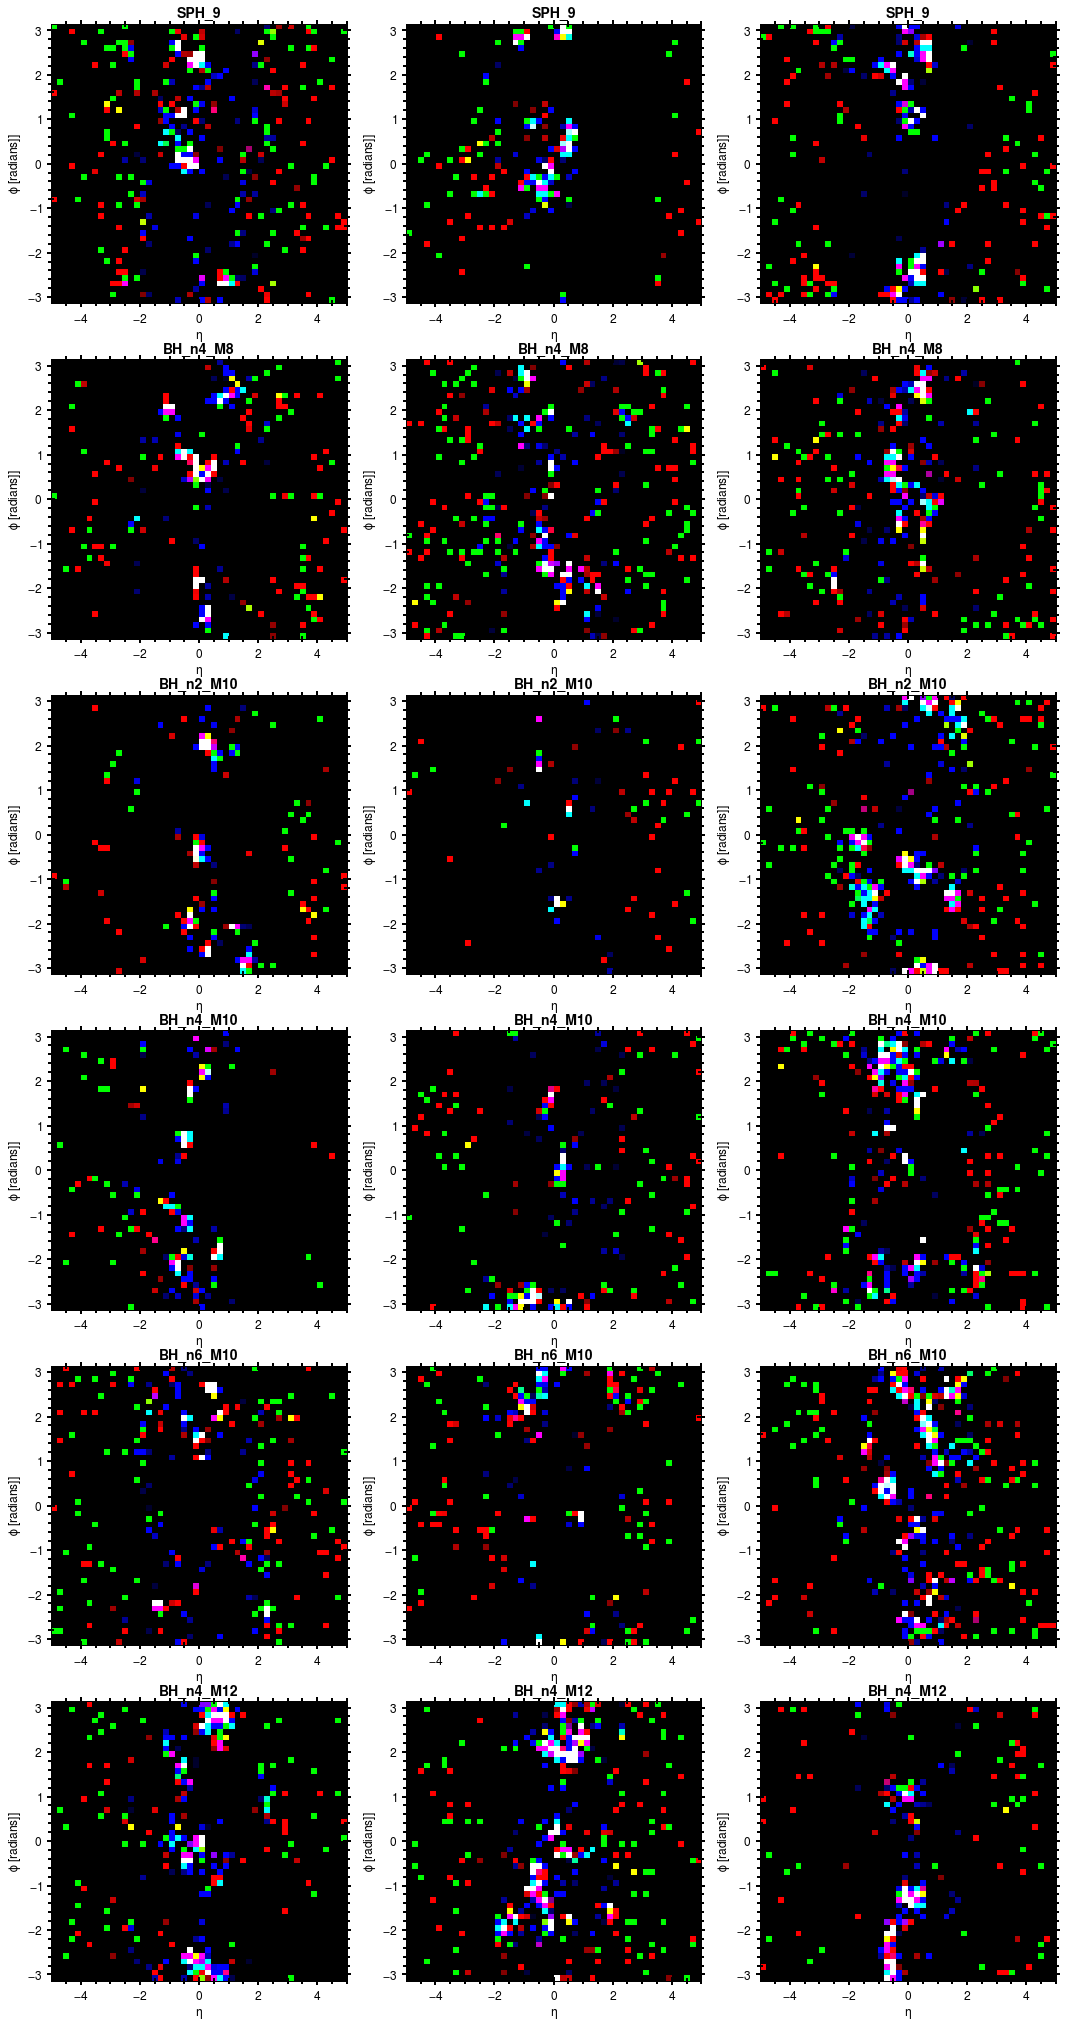

In [15]:
#Print some of the images
view_data(train_data, 3, CLASSES, PLOT_LABELS, RES, VAL_N_EVENTS)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Look at the highest histogram values values for a random image
[ 468.6197   503.07755  513.57495  547.31635  630.4362   654.2334
  788.5813  1181.0392  1576.2001 ]
Looking at image 14299


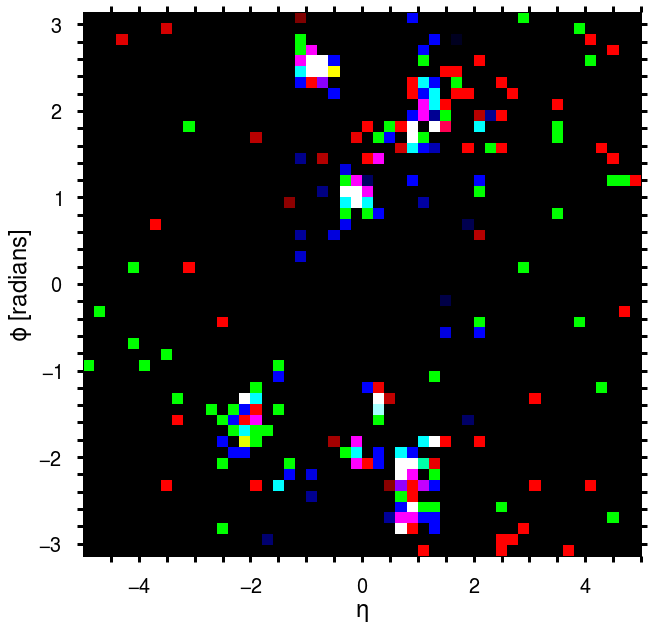

In [16]:
#Look at a random image more closely
k = np.random.randint(0, len(val_data))
image = val_data[k][0].cpu()
print("Look at the highest histogram values values for a random image")
print(np.sort(image.flatten())[-10:-1])
print("Looking at image", k)

fig, ax = plt.subplots(ncols=1, figsize=(10, 10))
ax.imshow(image, extent=[-5, 5, -np.pi, np.pi], aspect='auto')
cal_image_plot_paper(ax)
ax.tick_params(which="both", direction="out", bottom=True, left=True, labelsize=20, pad=15, length=6, width=3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


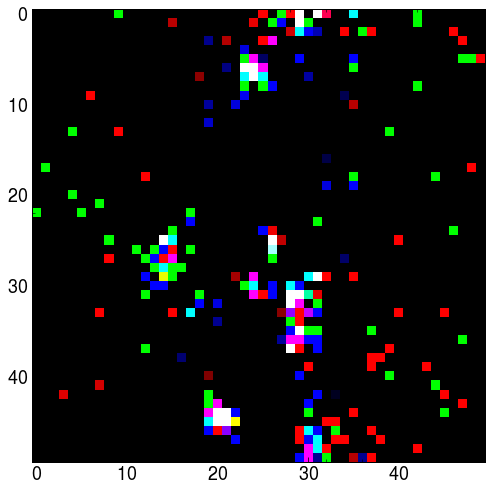

In [17]:
#Check augmentation on the same image
if transforms!=None:
    rolled_image = transforms(image)
    plt.imshow(rolled_image)

### Create net and train

In [18]:
#Create NN.
resnet = ResNet18(img_channels=3, num_classes=CLASSES)
resnet.to(DEVICE)
#Test that nothing major is wrong.
testimage, testlabel = val_data[0][0], val_data[0][1]
print(testimage.view(-1, 3, RES, RES).shape)
print(resnet(testimage.view(-1, 3, RES, RES).to(DEVICE)))
print(testlabel)

torch.Size([1, 3, 50, 50])
tensor([[ 0.2327, -0.7134,  0.4408,  0.4375, -0.1847, -0.4314]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([1., 0., 0., 0., 0., 0.], device='cuda:0', dtype=torch.float64)


In [19]:
#Set optimizer, learning rate scheduler and train the model
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
#scheduler = optim.lr_scheduler.CyclicLR(optimizer, 0.0001, 0.01, cycle_momentum=False)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.001*10, step_size_up=5, mode="exp_range", gamma=0.85, cycle_momentum=False)
training_results = train(resnet, train_data, val_data, 2**8, 40, RES, DEVICE, optimizer, scheduler)

100%|██████████| 40/40 [47:10<00:00, 70.75s/it]  


In [20]:
#Test that nothing major is wrong after training.
k = np.random.randint(0, len(val_data))
testimage, testlabel = val_data[k][0], val_data[k][1]
print(testimage.view(-1, 3, RES, RES).shape)
print(resnet(testimage.view(-1, 3, RES, RES).to(DEVICE)), testlabel)

torch.Size([1, 3, 50, 50])
tensor([[-0.0702, -1.7690,  0.3760,  0.0102, -0.0859, -2.3099]],
       device='cuda:0', grad_fn=<AddmmBackward0>) tensor([0., 0., 0., 1., 0., 0.], device='cuda:0', dtype=torch.float64)


### Inspect the results

(0.0, 1.8)

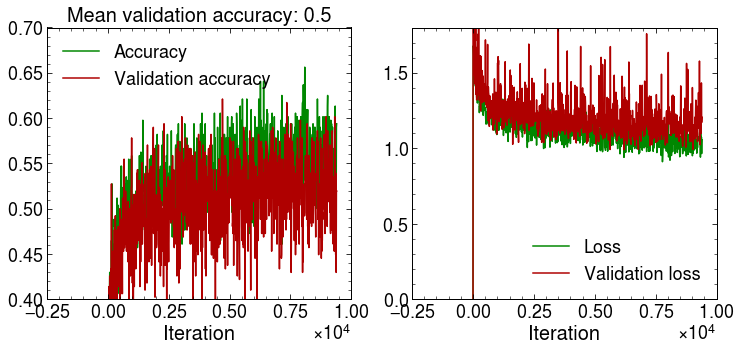

In [21]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
training_results.plot("Iteration", ["Accuracy", "Validation accuracy"], ax=axs[0], 
                    title="Mean validation accuracy: " + str(round(training_results["Validation accuracy"].mean(), 2)))
training_results.plot("Iteration", ["Loss", "Validation loss"], ax=axs[1])
axs[0].set_ylim(0.4,0.7)
#axs[0].set_xlim(0)
axs[1].set_ylim(0, 1.8)

### Predict on test set and check accuracy

In [22]:
truth, preds, losses, values = predict(resnet, test_data, CLASSES, 1, RES, DEVICE, return_loss=True, return_values=True)
confusion = pd.DataFrame(dict(zip(["Truth", "Predictions"], [truth, preds])))
accuracy = accuracy_score(truth, preds, normalize=True)

100%|██████████| 90000/90000 [09:15<00:00, 161.98it/s]


In [23]:
#Save model
torch.save(resnet.state_dict(), SAVE_PATH)

[0.921 0.051 0.023 0.002 0.001 0.001 0.132 0.648 0.092 0.065 0.056 0.007
 0.131 0.145 0.39  0.163 0.13  0.041 0.076 0.169 0.291 0.21  0.209 0.045
 0.056 0.188 0.252 0.208 0.248 0.047 0.025 0.03  0.139 0.08  0.112 0.615]


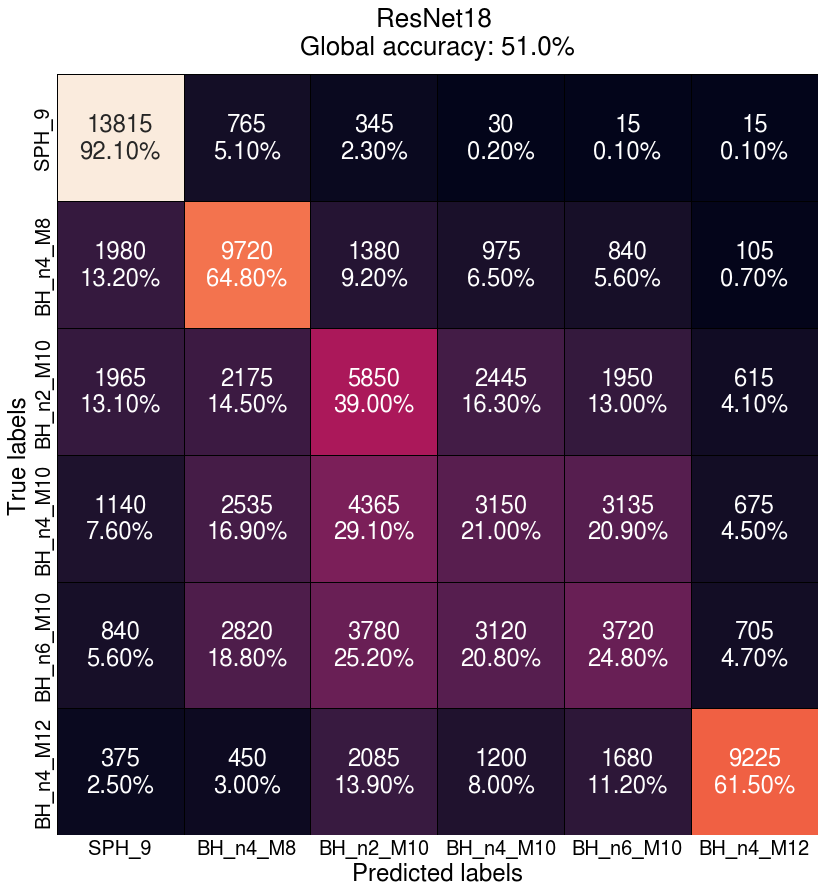

In [24]:
def plot_conf_matrix(confusion, accuracy, labels):
    """
    plot confusion matrix
    """
    fig, ax = plt.subplots(1,1, figsize=(14, 14))

    #Generate the confusion matrix
    cf_matrix = confusion_matrix(confusion["Truth"], confusion["Predictions"], normalize="true")
    cf_matrix = np.round(cf_matrix, 3)
    print(cf_matrix.flatten())
    group_counts = ["{0:0.0f}".format(value*TEST_N_EVENTS) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()]
    annot = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
    annot = np.asarray(annot).reshape(len(labels),len(labels))
    sn.heatmap(
            cf_matrix, 
            ax=ax, 
            annot=annot, 
            cmap='rocket', 
            linewidths=1.0, 
            linecolor='black',
            cbar = False, 
            square=True, 
            fmt='', 
            cbar_kws={'format':'%.0f'},
            annot_kws={"size": 24}
        )

    #ax.set_title('Confusion matrix\n\n', size=24)
    ax.set_xlabel('Predicted labels', size=24)
    ax.set_ylabel('True labels', size=24)

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(labels, size=20)
    ax.yaxis.set_ticklabels(labels, size=20)
    ax.tick_params(which="both", left=False, bottom=False, top=False, right=False)
    ax.set_title(f"ResNet18 \nGlobal accuracy: {round(accuracy, 2)*100}%", size=26, pad=20)

    ## Display the visualization of the Confusion Matrix.
    plt.show()
plot_conf_matrix(confusion, accuracy, PLOT_LABELS)

In [25]:
confusion["Event_ID"] = np.arange(0, len(confusion))
confusion["Correct_Pred"] = [confusion["Predictions"][i] == confusion["Truth"][i] for i in range(len(confusion))]
confusion["Losses"] = losses
confusion["Class_1_value"] = values[:,0]
confusion["Class_2_value"] = values[:,1]
confusion["Difference"] = abs(confusion["Class_1_value"] - confusion["Class_2_value"])
arg_chosen_value = np.asarray(preds.tolist())
chosen_value = [values[i, int(arg)].tolist() for i, arg in enumerate(arg_chosen_value)]
confusion["Best choice"] = chosen_value
wrong_id = confusion[confusion["Correct_Pred"]==False]["Event_ID"].tolist()

In [26]:
confusion

,Truth,Predictions,Event_ID,Correct_Pred,Losses,Class_1_value,Class_2_value,Difference,Best choice
0,0.0,0.0,0,True,0.551710,5.759641e-01,1.577888e-01,4.181753e-01,0.575964
1,0.0,0.0,1,True,0.114186,8.920920e-01,3.945290e-02,8.526391e-01,0.892092
2,0.0,0.0,2,True,0.034820,9.657788e-01,3.593903e-03,9.621849e-01,0.965779
3,0.0,0.0,3,True,1.317184,2.678886e-01,1.215324e-01,1.463562e-01,0.267889
4,0.0,0.0,4,True,0.278809,7.566844e-01,2.584913e-02,7.308353e-01,0.756684
...,...,...,...,...,...,...,...,...,...
89995,5.0,5.0,89995,True,0.025985,3.962425e-09,7.029557e-06,7.025595e-06,0.974350
89996,5.0,5.0,89996,True,0.288493,1.626097e-06,8.992202e-05,8.829592e-05,0.749392
89997,5.0,2.0,89997,False,4.376085,4.893662e-05,1.340812e-02,1.335918e-02,0.386229
89998,5.0,5.0,89998,True,0.448954,4.352178e-04,1.032853e-03,5.976356e-04,0.638295


In [27]:
confusion.sort_values(by=["Losses"], ascending=False, inplace=True, ignore_index=True)
#confusion.sort_values(by=["Correct_Pred"], ascending=True, inplace=True, ignore_index=True)
#print(confusion[confusion["Truth"]>0])
print(confusion)

       Truth  Predictions  Event_ID  Correct_Pred        Losses  \
0        5.0          3.0     78817         False  1.267589e+01   
1        5.0          0.0     78455         False  1.239226e+01   
2        1.0          5.0     20042         False  1.196329e+01   
3        5.0          0.0     82151         False  1.163146e+01   
4        5.0          3.0     83837         False  1.127743e+01   
...      ...          ...       ...           ...           ...   
89995    5.0          5.0     81307          True  2.384186e-07   
89996    5.0          5.0     88162          True  1.192093e-07   
89997    5.0          5.0     81228          True  1.192093e-07   
89998    5.0          5.0     78841          True  0.000000e+00   
89999    5.0          5.0     89705          True  0.000000e+00   

       Class_1_value  Class_2_value    Difference  Best choice  
0       3.778424e-07   9.548990e-04  9.545212e-04     0.547182  
1       9.910402e-01   1.781699e-03  9.892585e-01     0.991040  


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Look at the highest histogram values values for the hardest to classify image
[ 530.8902   536.5022   536.9626   686.58057  928.6999  1327.8623
 1444.8323  1550.1101  3584.5393 ]
Looking at image 78817


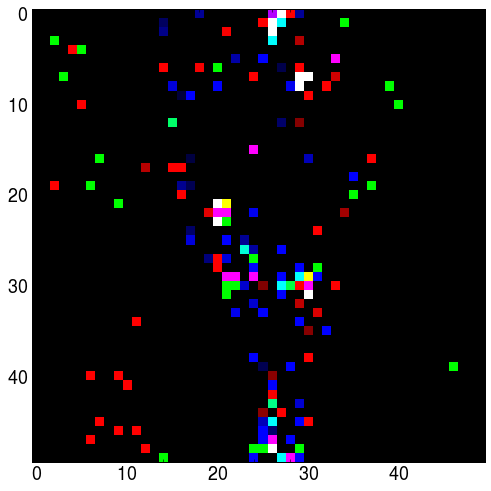

In [28]:
k = confusion["Event_ID"][0]
image = test_data[k][0].cpu()
print("Look at the highest histogram values values for the hardest to classify image")
print(np.sort(image.flatten())[-10:-1])
print("Looking at image", k)

plt.imshow(image)

Text(0.5, 0, 'Softmax(y)')

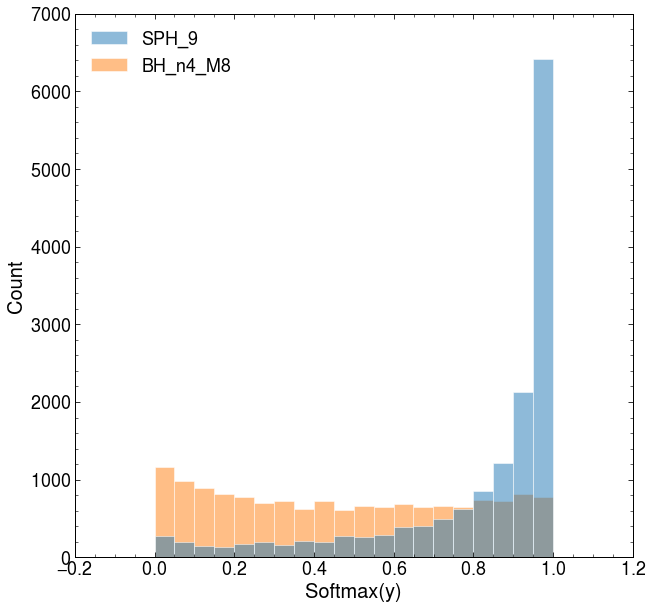

In [29]:
sph_softmax = confusion[confusion["Truth"]==0]["Class_1_value"]
bh_softmax = confusion[confusion["Truth"]==1]["Class_2_value"]
softmaxes = dict(zip(PLOT_LABELS, [sph_softmax, bh_softmax]))

fig, ax = plt.subplots(ncols=1, figsize=(10, 10))
sn.histplot(softmaxes, ax=ax, multiple="layer", stat="count", palette="tab10", bins=20)
sn.move_legend(ax, "upper left")
#ax.set_yscale("log")
ax.set_xlabel("Softmax(y)")